# Main idea

### Collect and structure data

The algorithm to make decision for trading based on technique factors, there are: <br>
- Moving Average with period 10: If MA10 up-cross Close price line then Buy and be annotated 1, otherwise is 0 
- Moving Average with period 20: If MA20 up-cross Close price line then Buy and be annotated 1, otherwise is 0
- Weight Moving Average with period 10: the same way to use with above indicators 
- Weight Moving Average with period 20: : the same way to use with above indicators 
- RSI(14): If current RSI greater than last RSI then 1, others is 0
- MACD: If current MACD greater than last MACD then 1, others is 0
- MACD signal: Calculate different between Signal line and MACD line. If it is greater than 0 then 1, others is 0 

Target variable is based on ROC (rate of change) of close price between t+3 and t time span. If $ \frac{P_{t+3}}{P_t} -1 > 0$ then label 1 and others is 0. (In Vietnam stock market, investors sell stocks if and only if enough 3 days after buying and the return is actually consideration.


Please refer this link to find more information: https://www.investopedia.com/terms/t/technicalanalysis.asp

### Build model classify Buy/Sell with technical indicators

### Apply model with unseen data



# Collect and structure data

In [1]:
# import pandas.io.data as web
from datetime import datetime
import numpy as np
import pandas as pd
# import plotly.plotly as py

In [9]:
HSX = pd.read_excel('data/VNINDEX.xlsx',index_col='Date/Time')

In [11]:
HSX.index = pd.to_datetime(HSX.index, format='%Y%m%d')

In [12]:
HSX.head()

,Ticker,Close
Date/Time,,
2017-01-03,VNINDEX,672.01
2017-01-04,VNINDEX,674.70
2017-01-05,VNINDEX,675.81
2017-01-06,VNINDEX,679.80
2017-01-09,VNINDEX,682.57


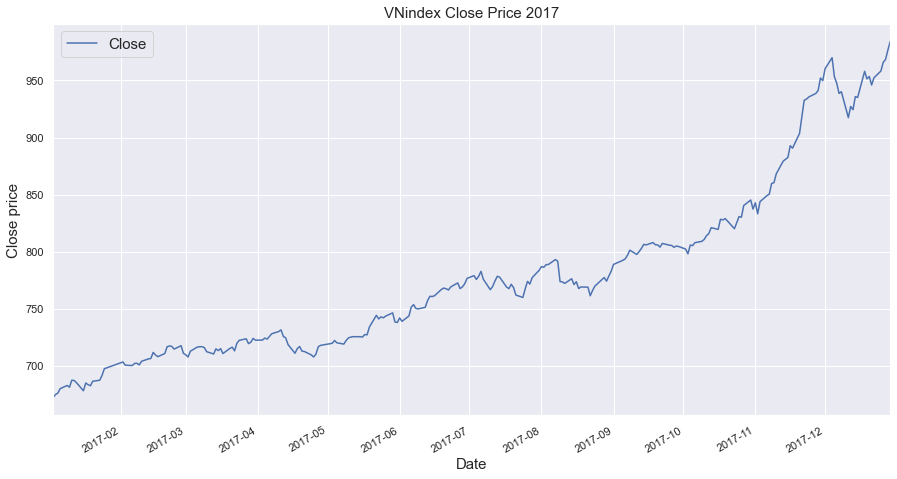

In [282]:
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
seaborn.set()
plt.figure(figsize=(15,8))
HSX['Close'].plot()
plt.ylabel('Close price', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.legend(loc='upper left',fontsize=15)
plt.title("VNindex Close Price 2017", fontsize = 15)
plt.show()

## Get feature based on technical idicators

In [27]:
from ta.trend import sma_indicator, EMAIndicator,macd_diff,macd,wma_indicator,CCIIndicator
from ta.volume import MFIIndicator
from ta.momentum import rsi,roc,WilliamsRIndicator,stochrsi_d,stochrsi_k
import pandas as pd

feature_df = pd.DataFrame()

# Initialize Bollinger Bands Indicator
feature_df['close'] = HSX['Close']
feature_df['indicator_sma10'] = sma_indicator(HSX['Close'],10)
feature_df['indicator_sma20']= sma_indicator(HSX['Close'],20)
feature_df['indicator_wma10']= wma_indicator(HSX['Close'],10)
feature_df['indicator_wma20']= sma_indicator(HSX['Close'],20)
feature_df['rsi'] = rsi(HSX['Close'],14)
feature_df['macd']=macd(HSX['Close'])
feature_df['macd_signal']=macd_diff(HSX['Close'])
feature_df['roc'] = roc(HSX['Close'],3)

In [28]:
feature_df['label']=[1 if i >= 0.01 else 0 for i in feature_df['roc'] ]
feature_df['label']=feature_df['label'].shift(-3)

In [40]:
feature_df=feature_df.dropna()

In [283]:
feature_df.head()

,close,indicator_sma10,indicator_sma20,indicator_wma10,indicator_wma20,rsi,macd,macd_signal,roc,label
Date/Time,,,,,,,,,,
2017-02-24,714.47,711.663,705.2185,713.518545,705.2185,71.711118,8.157802,0.229523,-0.290280,0.0
2017-02-27,717.44,712.817,706.7330,714.568909,706.7330,74.275989,8.132178,0.163120,0.027885,0.0
2017-02-28,710.79,713.270,707.7045,714.200364,707.7045,60.950658,7.488944,-0.384092,-0.848131,1.0
2017-03-01,709.52,713.065,708.3165,713.518545,708.3165,58.781761,6.798331,-0.859764,-0.692821,1.0
2017-03-02,707.51,712.881,708.5330,712.508545,708.5330,55.420458,6.019437,-1.310926,-1.384088,1.0


In [284]:
import warnings
warnings.simplefilter("ignore")
signal_df = pd.DataFrame()
signal_df['init']= 0*feature_df['indicator_sma10']

signal_df['sig_sma10']= -1
signal_df['sig_sma10'][feature_df['close']> feature_df['indicator_sma10']]=1
signal_df['sig_sma20']= -1
signal_df['sig_sma20'][feature_df['close']> feature_df['indicator_sma20']]=1

signal_df['sig_wma10']= -1
signal_df['sig_wma10'][feature_df['close']>=feature_df['indicator_wma10']]=1
signal_df['sig_wma20']= -1
signal_df['sig_wma20'][feature_df['close']>=feature_df['indicator_wma20']]=1

signal_df['sig_rsi']= -1
signal_df['sig_rsi'][feature_df.rsi >= feature_df.rsi.shift()]=1

signal_df['sig_macd']= -1
signal_df['sig_macd'][feature_df.macd >= feature_df.macd.shift()]=1

signal_df['sig_macd_diff']= -1
signal_df['sig_macd_diff'][feature_df.macd_signal >= 0]=1

signal_df['label'] = feature_df['label']
signal_df.astype(int).head()

,init,sig_sma10,sig_sma20,sig_wma10,sig_wma20,sig_rsi,sig_macd,sig_macd_diff,label
Date/Time,,,,,,,,,
2017-02-24,0,1,1,1,1,-1,-1,1,0
2017-02-27,0,1,1,1,1,1,-1,1,0
2017-02-28,0,-1,1,-1,1,-1,-1,-1,1
2017-03-01,0,-1,1,-1,1,-1,-1,-1,1
2017-03-02,0,-1,-1,-1,-1,-1,-1,-1,1


# Build Model classify

## Build model for VNINDEX

In [44]:
# Import train_test_split function
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [163]:
X_train = signal_df[signal_df.index<'2017-08-01'].drop(['init','label'],axis=1)
y_train = signal_df[signal_df.index<'2017-08-01']['label']

X_val = signal_df[(signal_df.index>='2017-08-01') & (signal_df.index<'2017-10-01')].drop(['init','label'],axis=1)
y_val = signal_df[(signal_df.index>='2017-08-01') & (signal_df.index<'2017-10-01')]['label']

X_test = signal_df[(signal_df.index>='2017-10-01')].drop(['init','label'],axis=1)
y_test = signal_df[(signal_df.index>='2017-10-01')].drop(['init','label'],axis=1)

In [164]:
# import the class
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
# fit the model with data
logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_val)
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))

Accuracy: 0.627906976744186


In [171]:
y_pred=pd.DataFrame(logreg.predict(X_test))
y_pred=y_pred.set_index(X_test.index)

In [172]:
val_close = HSX.loc[X_test.index]

In [212]:
signal = []
signal = [y_pred[0][0]]
time_ind = [y_pred.index[0]]
for i, val in enumerate(np.array(y_pred)):
    if (val == 1) & (signal[-1] == 0):
        signal.append(1)
        time_ind.append(y_pred.index[i])
    elif (val == 1) & (signal == 1):
        continue
    elif (val == 0) & (signal[-1] == 1) & ((y_pred.index[i] - time_ind[-1]).days>=3):
        signal.append(0)
        time_ind.append(y_pred.index[i])
    elif (val == 0) & (signal[-1] == 0):
        continue
    else:
        continue

## Validation with unseen data

In [281]:
arr = val_close.loc[np.array(time_ind), 'Close'].values
returns = np.diff( arr ) / arr[ : -1]
total_return = np.sum(returns)
print(total_return*100)

18.33975006895818


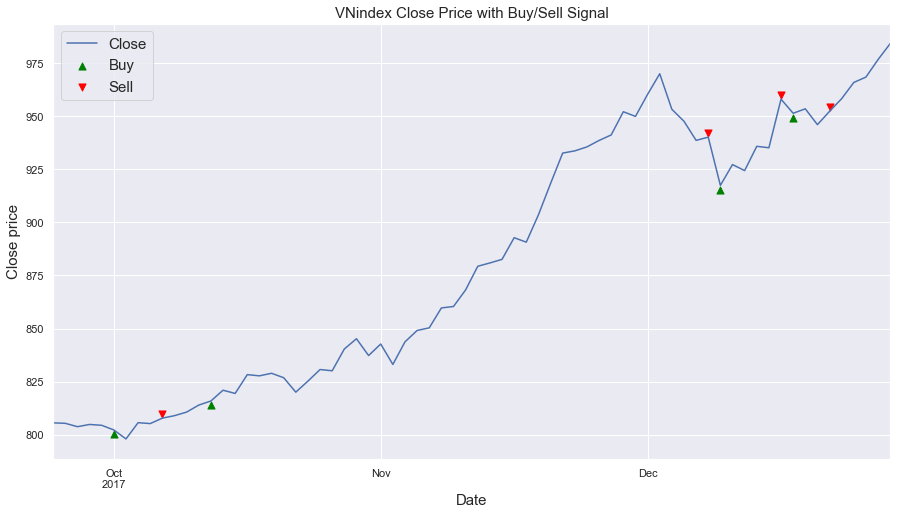

In [276]:
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
seaborn.set()
plt.figure(figsize=(15,8))
HSX[HSX.index>='2017-09-25']['Close'].plot()
plt.scatter(np.array(time_ind)[np.array(signal)==1], 
            val_close.loc[np.array(time_ind)[np.array(signal)==1], 'Close'].values - 2, 
            label='Buy', color='green', s=50, marker="^")
plt.scatter(np.array(time_ind)[np.array(signal)==0], 
            val_close.loc[np.array(time_ind)[np.array(signal)==0], 'Close'].values + 2, 
            label='Sell', color='red', s=50, marker="v")

plt.ylabel('Close price', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.legend(loc='upper left',fontsize=15)
plt.title("VNindex Close Price with Buy/Sell Signal", fontsize = 15)
plt.show()